# Caractérisation Illfurth

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt

In [2]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

In [56]:
df = pd.read_csv("data/position-nodes.csv", sep=';', index_col=0)

In [58]:
df

Distance  Azimut    SN
Node                         
R0            0       0  2606
R1-01         5      37  3514
R1-02         5      97   295
R1-03         5     157  4565
R1-04         5     217   891
R1-05         5     277  2464
R1-06         5     337  2293
R2-01        15       7  2023
R2-02        15      67  2710
R2-03        15     127  1411
R2-04        15     187   626
R2-05        15     247   152
R2-06        15     307  2636
R3-01        45      37   501
R3-02        45      97  2660
R3-03        45     157  1435
R3-04        45     217  2786
R3-05        45     277   582
R3-06        45     337   757
R4-01       135       7  1030
R4-02       135      63  1460
R4-03       135     123  1607
R4-04       135     179  5270
R4-05       135     242  1689
R4-06       135     303    43
R5-01       335       5   593
R5-02       335      85  2041
R5-03       335     155  1076
R5-04       335     223   956
R5-05       335     293  2588

In [24]:
out_path = 'out/'
path = 'data/ILLF_carac/' # chemin vers les données
coords = (47.6831736, 7.2543831)
files = os.listdir(path) # liste les fichiers miniseed du dossier ILLF
step = 60

## Charger les traces des capteurs

In [6]:
def node_filenames(SN):
    """renvoie le fichier correspondant au numéro de série"""
    return [i for i in files if i[5:9]==str(SN)]

In [7]:
def load_node_S(SN):
    """renvoie le stream des traces du capteur de numéro de série SN en chargeant le fichier"""
    S = Stream()
    for filename in node_filenames(SN):
        S += read(path + filename)
    return S

In [32]:
S = Stream()
for row in df.iterrows():
    node, serie = row
    Scapt = load_node_S(serie.SN)
    for T in Scapt:
        T.stats.node = node
        T.stats.distance = float(serie.Distance)/1000  # distance en m
    S += Scapt

In [9]:
def node_SN(SN):
    """renvoie le stream des traces du capteur de numéro de série SN en le récupérant du stream"""
    return S.select(id=f'SS.*{SN}..DL*')

In [17]:
def node_S(name):
    """renvoie le stream des traces du node de nom name (R0, R1-4...) en le récupérant du stream"""
    return Stream(T for T in S if T.stats.node.startswith(name))

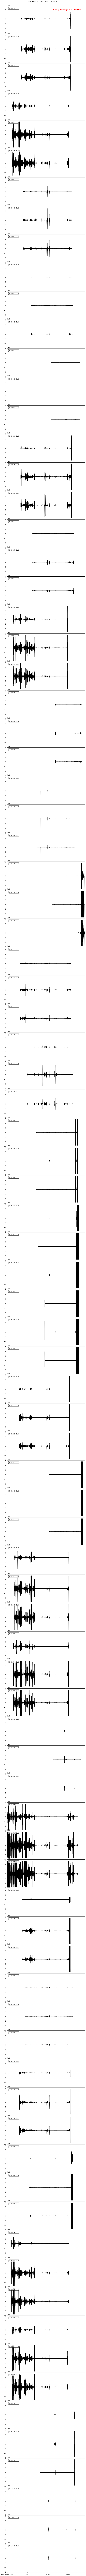

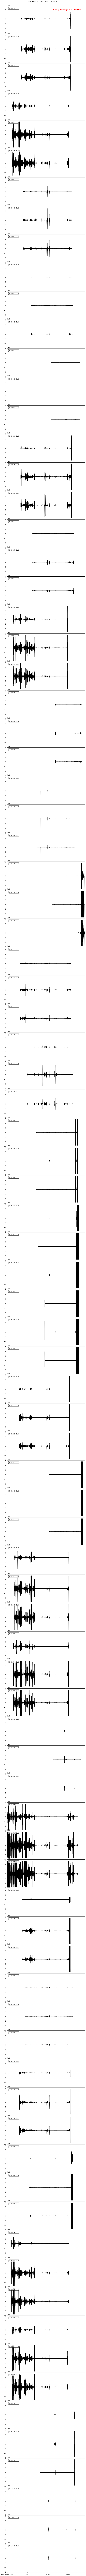

In [12]:
S.plot()
# S.plot(type='section')

## Intervalle d'étude

### Automatique

In [10]:
times = []
for T in S:
    times.append((T.stats.starttime, T.stats.endtime))
starttime = max(i[0] for i in times) + 2*60
endtime = min(i[1] for i in times) - 5*60

In [33]:
starttime = UTCDateTime(2021,10,29,10,25,0)
endtime = UTCDateTime(2021,10,29,10,50,0)

## Analyse H/V

### Filtration et nettoyage préliminaire des traces

In [27]:
def preprocess(S, starttime=starttime, endtime=endtime, fact_decim=5):
    """nettoye, filtre et découpe les traces"""
    S = S.trim(starttime, endtime) # retirer les parties inutiles et égaliser la durée de mesure
    S.detrend("demean")
    S.taper(0.05)
    S.decimate(fact_decim)

In [34]:
preprocess(S)

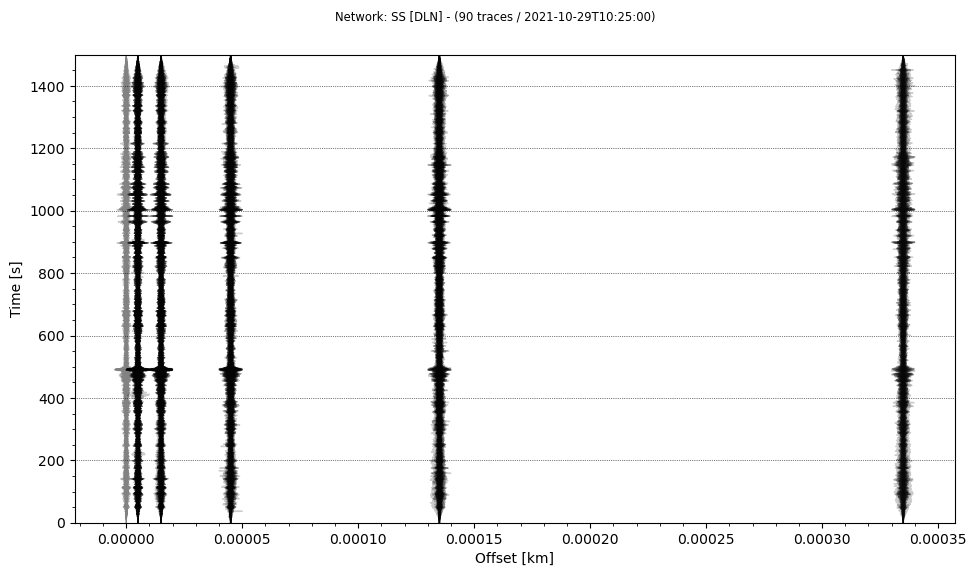

In [17]:
ax = S.plot(type='section', method='full', scale=2, alpha=0.2)
# outfile=os.path.join(out_path, 'traces.png')

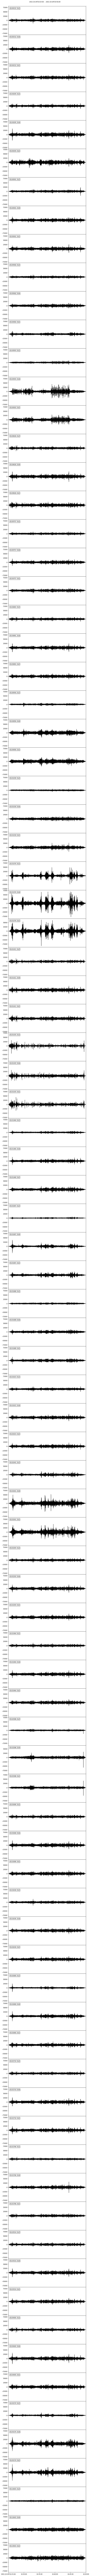

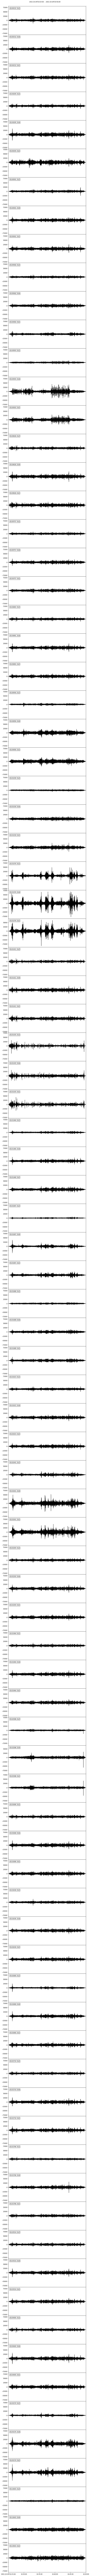

In [19]:
S.plot()

### Calcul H/V pour chaque segment

In [35]:
def segments(S, starttime=starttime, endtime=endtime, step=step, fmin=1, fmax=50, fact_smooth=50):
    """calcul le rapport H/V pour chaque segments"""
    T = np.arange(starttime, endtime, step)
    HV = []
    F = []
    for t in T:
        Scut = S.slice(t,t+step)
        Scut.sort(keys=['channel'])
        npts = Scut[0].stats.npts
        dt = Scut[0].stats.delta
        TF = np.zeros((3,npts))
        for i,T in enumerate(Scut):
            TF[i,:] = np.abs(np.fft.fft(T.data))
        f = np.fft.fftfreq(npts,dt)
        ii = np.where((f>=fmin) & (f<=fmax))[0]
        TF = TF[:,ii]
        f = f[ii]
        TFs = konno_ohmachi_smoothing(TF,f,bandwidth=fact_smooth)
        F.append(f)
        HV.append(np.sqrt(0.5*(TFs[0,:]**2+TFs[1,:]**2)) / TFs[2,:])
    HV = np.array(HV)
    return F, HV

In [36]:
def geometric_mean(values, N):
    """renvoie la moyenne géométrique"""
    return np.power(10, np.sum(np.log10(values), axis=0)/N)

#### Exemple

In [37]:
# node = node_SN('2710')
Snode = node_S('R2-02')
F, HV = segments(Snode)
HVs = geometric_mean(HV, np.shape(HV)[0])

Text(0, 0.5, 'H/V')

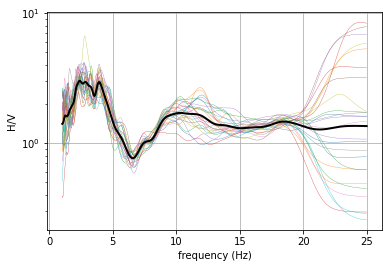

In [38]:
plt.clf()
for k, hv in enumerate(HV):
    plt.semilogy(F[k],hv,linewidth=0.3)
plt.semilogy(F[k],HVs,linewidth=2,color='k')
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('H/V')

## Généralisation

R0
R1-01
R1-02
R1-03
R1-04
R1-05
R1-06
R2-01
R2-02
R2-03
R2-04
R2-05
R2-06
R3-01
R3-02
R3-03
R3-04
R3-05
R3-06
R4-01
R4-02
R4-03
R4-04
R4-05
R4-06
R5-01
R5-02
R5-03
R5-04
R5-05


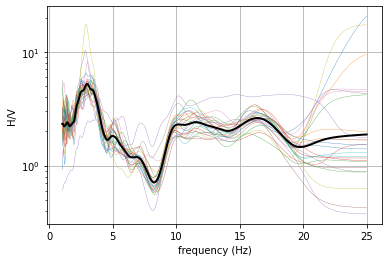

In [39]:
HVs_node = []
for row in df.iterrows():
    name = row[0]
    print(name)
    Snode = node_S(name) # récupération des traces d'une node qui a été filtré
    F, HV = segments(Snode)
    HVs = geometric_mean(HV, np.shape(HV)[0])
    HVs_node.append(HVs)
    plt.clf()
    for k, hv in enumerate(HV):
        plt.semilogy(F[k],hv,linewidth=0.3)
    plt.semilogy(F[k],HVs,linewidth=2,color='k')
    plt.grid()
    plt.xlabel('frequency (Hz)')
    plt.ylabel('H/V')
    plt.savefig(f'out/test2/{name}.png')
    plt.ylim = (0, 10)

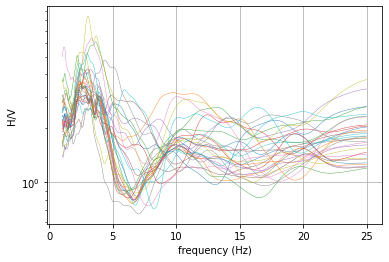

In [60]:
for HVs in HVs_node:
    plt.semilogy(F[0], HVs, linewidth=0.4)
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('H/V')
plt.savefig(f'out/averageHV.png')